In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import json
import random
from sklearn.decomposition import PCA

# Load data

## Load subsampled dataset with metrics

In [2]:
df = pd.read_csv("combined_actin_compression_metrics_all_velocities_and_repeats_subsampled_with_metrics.csv")

## Process dataset

In [3]:
# Apply relevant scaling to cytosim 
df_cytosim = df[df["simulator"] == "cytosim"].copy()
df_cytosim["xpos"] = df_cytosim["xpos"] * 1000
df_cytosim["ypos"] = df_cytosim["ypos"] * 1000
df_cytosim["zpos"] = df_cytosim["zpos"] * 1000

# Apply relevant scaling to readdy
df_readdy = df[df["simulator"] == "readdy"].copy()

# Combine scaled dataframes
df_rescaled = pd.concat([df_cytosim, df_readdy])

In [4]:
def align_fiber(coords):
    """
    Aligns an array of x, y, z positions along the positive x axis
    """

    # Identify rotation angle based on distance to point furthest from (0,0)
    distances = np.sqrt(np.sum(coords[:,1:] ** 2, axis=1))  
    max_index = np.argmax(distances)
    angle = np.arctan2(coords[max_index, 2], coords[max_index, 1])

    # Create rotation matrix
    c, s = np.cos(angle), np.sin(angle)
    R = np.array(((c, -s), (s, c)))

    # Rotate y and z
    rotated = np.dot(coords[:,1:], R)

    return np.concatenate((coords[:,0:1], rotated), axis=1)

## Plot unaligned fibers

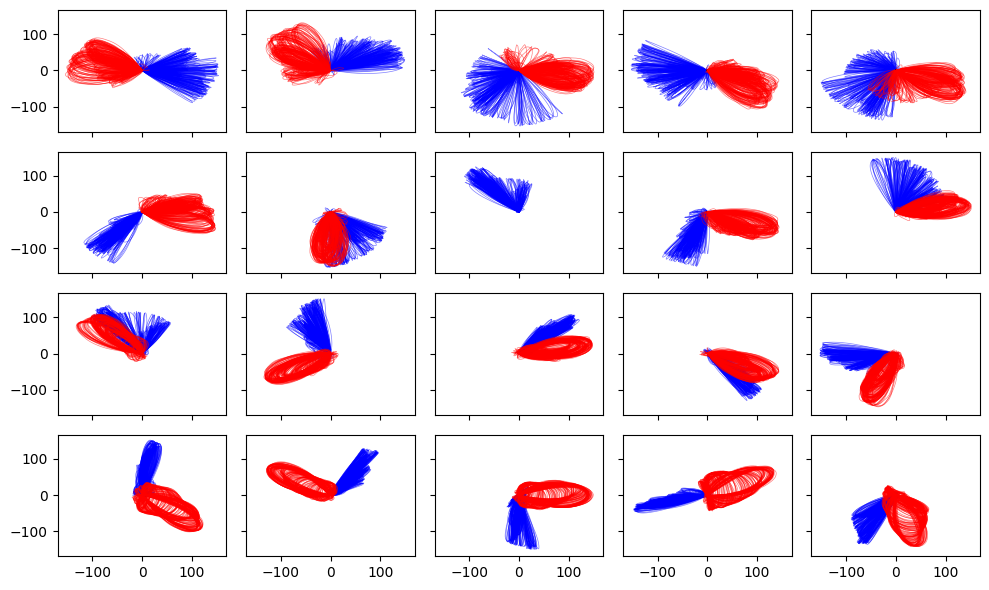

In [5]:
_, ax = plt.subplots(4, 5, figsize=(10,6), sharey=True, sharex=True)
velocities = [4.7, 15, 47, 150]

for (time, velocity, repeat, simulator), group in df_rescaled.groupby(["time", "velocity", "repeat", "simulator"]):
    color = "red" if simulator == "readdy" else "blue"
    row = velocities.index(velocity)
    col = repeat
    
    coords = group[["xpos", "ypos", "zpos"]].values

    ax[row,col].plot(coords[:,1], coords[:,2], lw=0.5, color=color, alpha=0.5)

plt.tight_layout()

## Plot aligned fibers

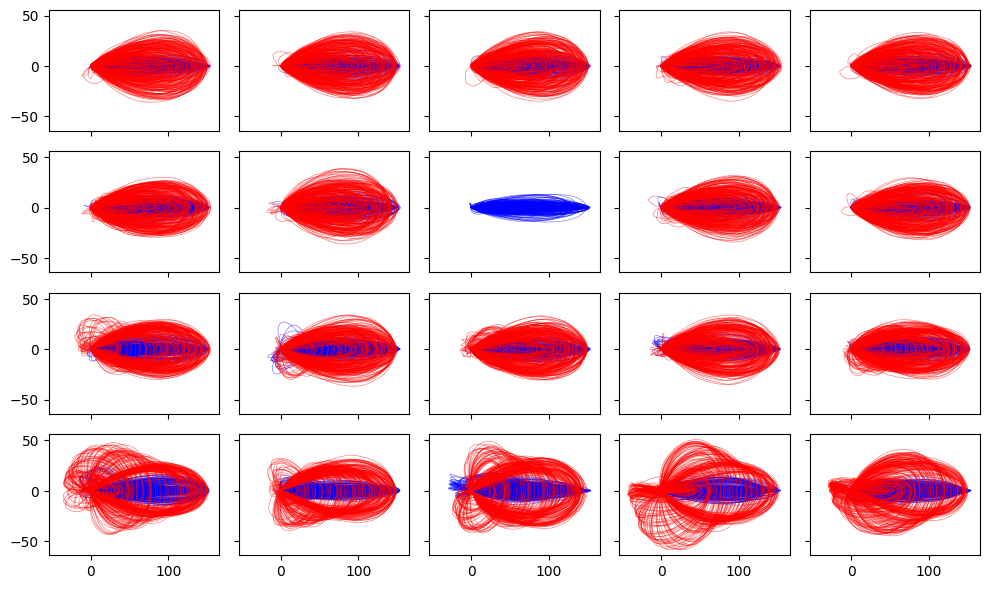

In [6]:
_, ax = plt.subplots(4, 5, figsize=(10,6), sharey=True, sharex=True)
velocities = [4.7, 15, 47, 150]

for (time, velocity, repeat, simulator), group in df_rescaled.groupby(["time", "velocity", "repeat", "simulator"]):
    color = "red" if simulator == "readdy" else "blue"
    row = velocities.index(velocity)
    col = repeat
    
    coords = group[["xpos", "ypos", "zpos"]].values
    if time == 0:
        fiber = coords
    else:
        fiber = align_fiber(coords)
        
    ax[row,col].plot(fiber[:,1], fiber[:,2], lw=0.5, color=color, alpha=0.5)

plt.tight_layout()

# Run PCA

## Align fibers

In [7]:
aligned_fibers = []
fiber_features = []

for (time, velocity, repeat, simulator), group in df_rescaled.groupby(["time", "velocity", "repeat", "simulator"]):
    coords = group[["xpos", "ypos", "zpos"]].values
    
    if time == 0:
        fiber = coords.reshape(-1,1)
    else:
        fiber = align_fiber(coords).reshape(-1,1)
    
    aligned_fibers.append(fiber)
    fiber_features.append({
        "TIME": time,
        "VELOCITY": velocity,
        "REPEAT": repeat,
        "SIMULATOR": simulator.upper(),
        "COMPRESSION_RATIO": group["COMPRESSION_RATIO"].unique()[0],
        "PEAK_ASYMMETRY": group["PEAK_ASYMMETRY"].unique()[0],
        "NON_COPLANARITY": group["NON_COPLANARITY"].unique()[0],
    })

aligned_fibers = np.array(aligned_fibers).squeeze()
fiber_features = pd.DataFrame(fiber_features)

## Run PCA

In [8]:
pca = PCA(n_components=2)
pca = pca.fit(aligned_fibers)
transform = pca.transform(aligned_fibers)

## Plot PCs colored by features

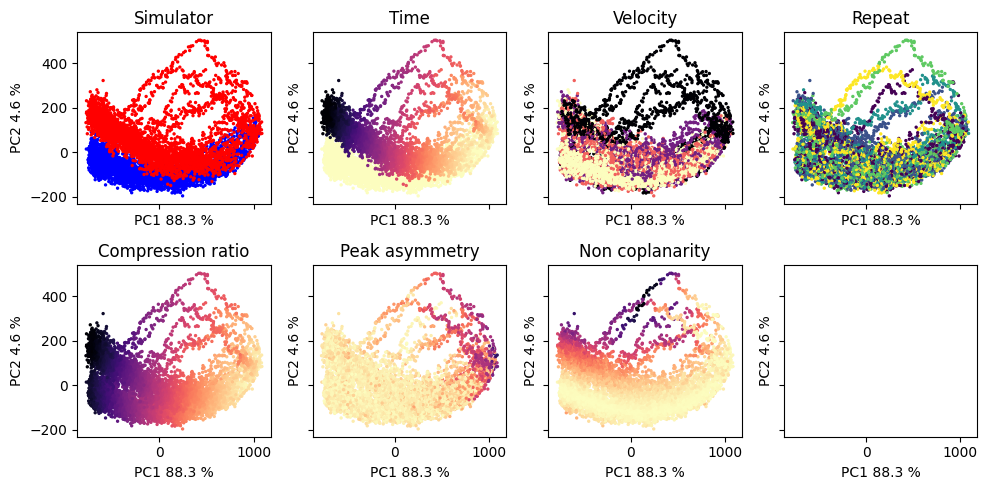

In [9]:
_, ax = plt.subplots(2, 4, figsize=(10,5), sharey=True, sharex=True)

simulator_map = {
    "READDY": "red",
    "CYTOSIM": "blue"
}
velocity_map = {
    4.7: 0,
    15: 1,
    47: 2,
    150: 3,
}

ax[0,0].scatter(transform[:,0], transform[:,1], s=2, c=fiber_features["SIMULATOR"].map(simulator_map))
ax[0,1].scatter(transform[:,0], transform[:,1], s=2, c=fiber_features["TIME"], cmap="magma_r")
ax[0,2].scatter(transform[:,0], transform[:,1], s=2, c=fiber_features["VELOCITY"].map(velocity_map), cmap="magma_r")
ax[0,3].scatter(transform[:,0], transform[:,1], s=2, c=fiber_features["REPEAT"])

ax[1,0].scatter(transform[:,0], transform[:,1], s=2, c=fiber_features["COMPRESSION_RATIO"], cmap="magma_r")
ax[1,1].scatter(transform[:,0], transform[:,1], s=2, c=fiber_features["PEAK_ASYMMETRY"], cmap="magma_r")
ax[1,2].scatter(transform[:,0], transform[:,1], s=2, c=fiber_features["NON_COPLANARITY"], cmap="magma_r")

features = ["Simulator", "Time", "Velocity", "Repeat", "Compression ratio", "Peak asymmetry", "Non coplanarity", ""]

for i in range(4):
    ax[0,i].set_title(features[i])
    ax[0,i].set_xlabel(f"PC1 {(pca.explained_variance_ratio_[0] * 100):.1f} %")
    ax[0,i].set_ylabel(f"PC2 {(pca.explained_variance_ratio_[1] * 100):.1f} %")

    ax[1,i].set_title(features[i + 4])
    ax[1,i].set_xlabel(f"PC1 {(pca.explained_variance_ratio_[0] * 100):.1f} %")
    ax[1,i].set_ylabel(f"PC2 {(pca.explained_variance_ratio_[1] * 100):.1f} %")

plt.tight_layout()
plt.show()

## Plot inverse transforms

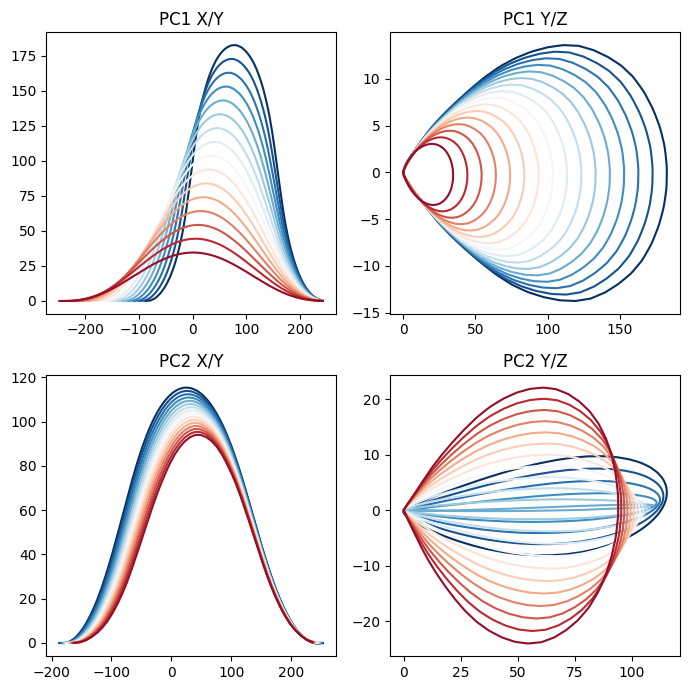

In [10]:
_, ax = plt.subplots(2, 2, figsize=(7,7))

points = np.arange(-2, 2, 0.25)
stdev = transform.std(axis=0)
cmap = plt.colormaps.get_cmap("RdBu_r")

for point in points:
    # Traverse PC 1
    fiber = pca.inverse_transform([point * stdev[0], 0]).reshape(-1,3)
    ax[0,0].plot(fiber[:,0], fiber[:,1], color=cmap((point + 2)/4))
    ax[0,1].plot(fiber[:,1], fiber[:,2], color=cmap((point + 2)/4))

    # Traverse PC 2
    fiber = pca.inverse_transform([0, point * stdev[1]]).reshape(-1,3)
    ax[1,0].plot(fiber[:,0], fiber[:,1], color=cmap((point + 2)/4))
    ax[1,1].plot(fiber[:,1], fiber[:,2], color=cmap((point + 2)/4))

ax[0,0].set_title("PC1 X/Y")
ax[0,1].set_title("PC1 Y/Z")
ax[1,0].set_title("PC2 X/Y")
ax[1,1].set_title("PC2 Y/Z")

plt.tight_layout()
plt.show()

# Save panel data

## Panel: simulated fibers

In [11]:
max_times = {
    ("cytosim", 4.7): 0.031685,
    ("cytosim", 15): 0.01,
    ("cytosim", 47): 0.00316,
    ("cytosim", 150): 0.001,
    ("readdy", 4.7): 1000,
    ("readdy", 15): 1000,
    ("readdy", 47): 1000,
    ("readdy", 150): 1000,
}

output = []

for (simulator, replicate, velocity, time), group in df_rescaled.groupby(["simulator", "repeat", "velocity", "time"]):
    if time != max_times[(simulator, velocity)]:
        continue

    coords = group[["xpos", "ypos", "zpos"]].values
    fiber = align_fiber(coords)

    output.append({
        "simulator": simulator.upper(),
        "replicate": int(replicate),
        "velocity": velocity,
        "x": fiber[:,0].tolist(),
        "y": fiber[:,1].tolist(),
        "z": fiber[:,2].tolist(),
    })

filename = f"actin_comparison_panel_simulated_fibers_data.json"
with open(filename, "w") as f:
    json.dump(output, f)

## Panel: fiber metrics

In [12]:
metrics = ["NON_COPLANARITY", "PEAK_ASYMMETRY"]
velocities = [4.7, 15, 47, 150]
output = {(metric, velocity): [] for metric in metrics for velocity in velocities}

for (simulator, replicate, velocity, monomer), group in df.groupby(["simulator", "repeat", "velocity", "monomer_ids"]):
    if monomer != 0:
        continue

    for metric in ["NON_COPLANARITY", "PEAK_ASYMMETRY"]:
        time = group["time"] / group["time"].max()
        
        output[(metric, velocity)].append({
            "simulator": simulator.upper(),
            "replicate": int(replicate),
            "x": time.tolist(),
            "y": group[metric].tolist(),
        })

for (metric, velocity), values in output.items():
    filename = f"actin_comparison_panel_fiber_metrics_data_{metric}_{int(velocity * 10):04d}.json"
    with open(filename, "w") as f:
        json.dump(values, f)

## Panel: pca trajectories

In [13]:
pca_results = pd.concat([pd.DataFrame(transform, columns=["PC1", "PC2"]), fiber_features], axis=1)

pca_trajectories = []

for (simulator, repeat, velocity), group in pca_results.groupby(["SIMULATOR", "REPEAT", "VELOCITY"]):
    pca_trajectories.append({
        "simulator": simulator.upper(),
        "replicate": int(repeat),
        "velocity": velocity,
        "x": group["PC1"].tolist(),
        "y": group["PC2"].tolist(),
    })

random.Random(1).shuffle(pca_trajectories)

with open("actin_comparison_panel_pca_trajectories_data.json", "w") as f:
    json.dump(pca_trajectories, f)

## Panel: pca features

In [14]:
pca_results = pd.concat([pd.DataFrame(transform, columns=["PC1", "PC2"]), fiber_features], axis=1)
pca_results = pca_results.sample(frac=1, random_state=1)
pca_results.to_csv("actin_comparison_panel_pca_features_data.csv")

## Panel: pca transform

In [18]:
output = []

pc1_points = [-600, -300, 0, 300, 600, 900]
pc2_points = [-200, 0, 200, 400]

for point in pc1_points:
    fiber = pca.inverse_transform([point, 0]).reshape(-1,3)
    output.append({
        "component": 1,
        "point": point,
        "x": fiber[:,0].tolist(),
        "y": fiber[:,1].tolist(),
        "z": fiber[:,2].tolist(),
    })
    
for point in pc2_points:
    fiber = pca.inverse_transform([0, point]).reshape(-1,3)
    output.append({
        "component": 2,
        "point": point,
        "x": fiber[:,0].tolist(),
        "y": fiber[:,1].tolist(),
        "z": fiber[:,2].tolist(),
    })

with open("actin_comparison_panel_pca_transform_data.json", "w") as f:
    json.dump(output, f)